<a href="https://colab.research.google.com/github/c4bath/cf860/blob/main/APTOS_EfficientNetV2B3_CLAHE_Binary_d5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File Details

Dataset: APTOS w CLAHE preprocessing

Model: MobileNetV2

Adapted from

Transfer learning and fine-tuning

https://www.tensorflow.org/tutorials/images/transfer_learning

coursera - Retinopathy Detection Using Deep Learning

 https://www.coursera.org/learn/retinopathy-detection-using-deep-learning/supplement/em4yb/project-based-course-overview



In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
import seaborn as sns
import plotly
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import matthews_corrcoef, classification_report, confusion_matrix,cohen_kappa_score
from sklearn.preprocessing import LabelEncoder

from plotly.offline import iplot, init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  6 02:32:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
os.listdir('/content/drive/MyDrive/train')

['Mild', 'Moderate', 'No_DR', 'Proliferative_DR', 'Severe']

In [6]:
# To have reproducible results
seed = 27

np.random.seed(seed)

tf.random.set_seed(seed)

num_classes = 2

IMG_SIZE = (224,224)

In [7]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('/content/drive/MyDrive/train'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/train', i))
  for j in train_class:
    img = os.path.join('train', i, j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))
print('Number of train labels : {} \n'.format(len(label)))

Number of train images : 3662 

Number of train labels : 3662 



In [8]:
No_images_per_class = []
Class_name = []
for i in os.listdir('/content/drive/MyDrive/train'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Mild = 370 

Number of images in Moderate = 999 

Number of images in No_DR = 1805 

Number of images in Proliferative_DR = 295 

Number of images in Severe = 193 



In [9]:
retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df

,Image,Labels
0,train/Mild/677f087cd697.png,Mild
1,train/Mild/ea15a290eb96.png,Mild
2,train/Mild/07929d32b5b3.png,Mild
3,train/Mild/35d6c4c50072.png,Mild
4,train/Mild/a5a2a7003d60.png,Mild
...,...,...
3657,train/Severe/bb7e0a2544cd.png,Severe
3658,train/Severe/38055d8b9f08.png,Severe
3659,train/Severe/36b5b3c9fb32.png,Severe
3660,train/Severe/51269b77d312.png,Severe


In [10]:
# List of classes to be relabeled as 'Yes_DR'
classes_to_relabel = ['Mild', 'Moderate', 'Severe', 'Proliferative_DR']

# Relabeling process
retina_df['Labels'] = retina_df['Labels'].replace(classes_to_relabel, 'Yes_DR')

print(retina_df['Labels'].value_counts())

Yes_DR    1857
No_DR     1805
Name: Labels, dtype: int64


In [11]:

# Assuming 'Labels' column in your DataFrame has 'No_DR' and 'Yes_DR'
retina_df['Encoded_Labels'] = retina_df['Labels'].replace({'No_DR': 0, 'Yes_DR': 1})



In [12]:
retina_df.head()

,Image,Labels,Encoded_Labels
0,train/Mild/677f087cd697.png,Yes_DR,1
1,train/Mild/ea15a290eb96.png,Yes_DR,1
2,train/Mild/07929d32b5b3.png,Yes_DR,1
3,train/Mild/35d6c4c50072.png,Yes_DR,1
4,train/Mild/a5a2a7003d60.png,Yes_DR,1


In [13]:
# Shuffle the data and split it into training, testing and validation
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.3)
val, test = train_test_split(test, test_size = 0.5)

In [14]:
train_datagen =  ImageDataGenerator(
    zoom_range=0.15,  # set range for random zoom, changed from 0.15 to 0.3, now changed from 0.3 to 0.45, from 0.45 to 0.6
    fill_mode='constant',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,# randomly flip images
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255)


# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
base_path = '/content/drive/My Drive/'  # Your base path

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Encoded_Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="raw",
    batch_size=32)

validation_generator = val_datagen.flow_from_dataframe(
    val,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Encoded_Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="raw",
    batch_size=32)

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Encoded_Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="raw",
    batch_size=32)


Found 2563 validated image filenames.
Found 549 validated image filenames.
Found 550 validated image filenames.


In [16]:
images, labels = next(test_generator)

In [17]:
example_image = images[0]
example_label = labels[0]


0


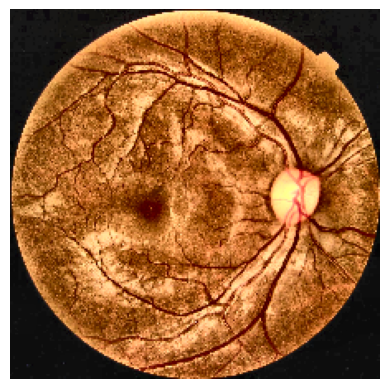

In [18]:
print(example_label)
plt.imshow(example_image)
plt.axis('off')  # To turn off the axis
plt.show()

In [19]:
'''
# Custom MCC for multiclass OLD
num_classes = 2

class MatthewsCorrelationCoefficient(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="matthews_correlation_coefficient", **kwargs):
        super(MatthewsCorrelationCoefficient, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.confusion_matrix = self.add_weight(
            name="confusion_matrix",
            shape=(num_classes, num_classes),
            initializer="zeros"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)

        new_confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, self.num_classes)
        new_confusion_matrix = tf.cast(new_confusion_matrix, self.confusion_matrix.dtype)

        return self.confusion_matrix.assign_add(new_confusion_matrix)

    def result(self):
        sum_over_row = tf.reduce_sum(self.confusion_matrix, axis=0)
        sum_over_col = tf.reduce_sum(self.confusion_matrix, axis=1)
        true_positives = tf.linalg.diag_part(self.confusion_matrix)
        predicted_positives = sum_over_row
        actual_positives = sum_over_col
        total_samples = tf.reduce_sum(sum_over_row)

        mcc_numerator = tf.reduce_sum(true_positives * total_samples - predicted_positives * actual_positives)
        mcc_denominator = tf.sqrt(
            (total_samples**2 - tf.reduce_sum(predicted_positives**2)) *
            (total_samples**2 - tf.reduce_sum(actual_positives**2))
        )

        mcc = mcc_numerator / mcc_denominator
        mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
        return mcc

    def reset_state(self):
        for s in self.variables:
            s.assign(tf.zeros_like(s))

    def get_config(self):
        config = super(MatthewsCorrelationCoefficient, self).get_config()
        config.update({"num_classes": self.num_classes})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

'''

'\n# Custom MCC for multiclass OLD\nnum_classes = 2\n\nclass MatthewsCorrelationCoefficient(tf.keras.metrics.Metric):\n    def __init__(self, num_classes, name="matthews_correlation_coefficient", **kwargs):\n        super(MatthewsCorrelationCoefficient, self).__init__(name=name, **kwargs)\n        self.num_classes = num_classes\n        self.confusion_matrix = self.add_weight(\n            name="confusion_matrix",\n            shape=(num_classes, num_classes),\n            initializer="zeros"\n        )\n\n    def update_state(self, y_true, y_pred, sample_weight=None):\n        y_pred = tf.argmax(y_pred, axis=1)\n        y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)\n\n        new_confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, self.num_classes)\n        new_confusion_matrix = tf.cast(new_confusion_matrix, self.confusion_matrix.dtype)\n\n        return self.confusion_matrix.assign_add(new_confusion_matrix)\n\n    def result(self):\n        sum_over_row = tf.reduce_s

In [20]:

class MatthewsCorrelationCoefficient(tf.keras.metrics.Metric):
    def __init__(self, name='mcc', **kwargs):
        super(MatthewsCorrelationCoefficient, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        true_pos = tf.cast(tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1))), tf.float32)
        false_pos = tf.cast(tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1))), tf.float32)
        true_neg = tf.cast(tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 0))), tf.float32)
        false_neg = tf.cast(tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0))), tf.float32)

        self.true_positives.assign_add(true_pos)
        self.false_positives.assign_add(false_pos)
        self.true_negatives.assign_add(true_neg)
        self.false_negatives.assign_add(false_neg)


    def result(self):
        numerator = (self.true_positives * self.true_negatives) - (self.false_positives * self.false_negatives)
        denominator = tf.sqrt((self.true_positives + self.false_positives) * (self.true_positives + self.false_negatives)
                              * (self.true_negatives + self.false_positives) * (self.true_negatives + self.false_negatives))

        return tf.cond(tf.equal(denominator, 0), lambda: 0.0, lambda: numerator / denominator)

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.true_negatives.assign(0)
        self.false_negatives.assign(0)




In [21]:
base_model = tf.keras.applications.EfficientNetV2B3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

52606240/52606240 [==============================] - 5s 0us/step


In [22]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1536)


In [23]:
base_model.trainable = False

In [24]:
# Display Model
base_model.summary()

Model: "efficientnetv2-b3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 40)         1080      ['normalizatio

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [26]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [27]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs) already augmented in train_generator
#x = preprocess_input(x) already rescaled in train and val_generator
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 12932159 (49.33 MB)
Trainable params: 1537 (6.0

In [29]:
len(model.trainable_variables)

2

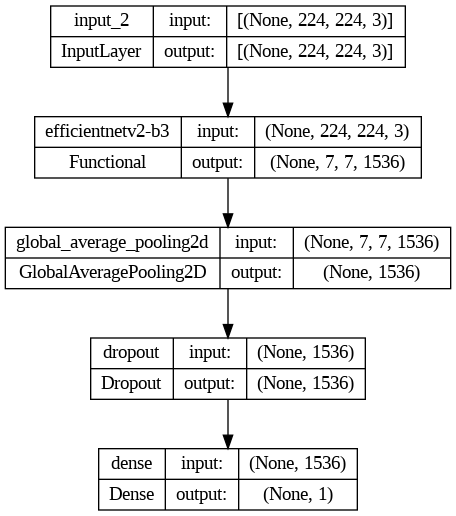

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [31]:

base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        MatthewsCorrelationCoefficient()
    ]
)

In [32]:
#apply early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#save the best model with lowest validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/drweights/EfficientNetV2B3_d5b.hdf5", verbose=1, save_best_only=True)


In [33]:
initial_epochs = 10

In [34]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = initial_epochs, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/10
80/80 [==============================] - ETA: 0s - loss: 0.7006 - accuracy: 0.4840 - mcc: -0.0331
Epoch 1: val_loss improved from inf to 0.69294, saving model to /content/drive/MyDrive/drweights/EfficientNetV2B3_d5b.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



80/80 [==============================] - 712s 9s/step - loss: 0.7006 - accuracy: 0.4840 - mcc: -0.0331 - val_loss: 0.6929 - val_accuracy: 0.5074 - val_mcc: 0.0000e+00
Epoch 2/10
80/80 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5286 - mcc: 0.0576
Epoch 2: val_loss improved from 0.69294 to 0.69138, saving model to /content/drive/MyDrive/drweights/EfficientNetV2B3_d5b.hdf5
80/80 [==============================] - 45s 558ms/step - loss: 0.6922 - accuracy: 0.5286 - mcc: 0.0576 - val_loss: 0.6914 - val_accuracy: 0.6452 - val_mcc: 0.3780
Epoch 3/10
80/80 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5137 - mcc: 0.0272
Epoch 3: val_loss improved from 0.69138 to 0.68994, saving model to /content/drive/MyDrive/drweights/EfficientNetV2B3_d5b.hdf5
80/80 [==============================] - 45s 566ms/step - loss: 0.6938 - accuracy: 0.5137 - mcc: 0.0272 - val_loss: 0.6899 - val_accuracy: 0.5239 - val_mcc: 0.1620
Epoch 4/10
80/80 [=================

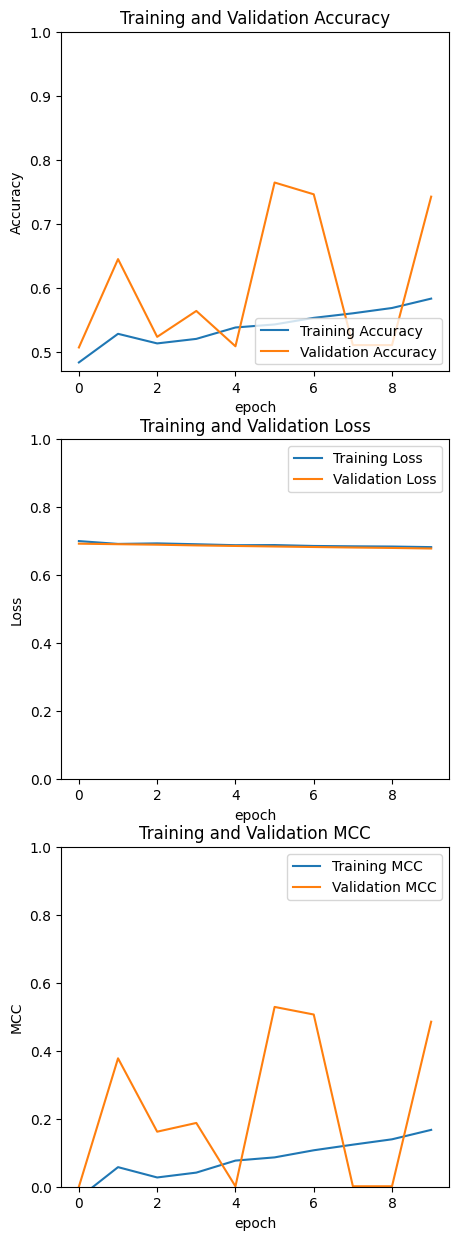

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

matthews_correlation_coefficient = history.history['mcc']
val_matthews_correlation_coefficient = history.history['val_mcc']

fig, axs = plt.subplots(3, 1, figsize=(5, 15))

plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')


plt.subplot(3, 1, 3)
plt.plot(matthews_correlation_coefficient, label='Training MCC')
plt.plot(val_matthews_correlation_coefficient, label='Validation MCC')
plt.legend(loc='upper right')
plt.ylabel('MCC')
plt.ylim([0,1.0])
plt.title('Training and Validation MCC')
plt.xlabel('epoch')
plt.show()

In [36]:
# Loss
min_loss_index = np.argmin(history.history['loss'])
min_loss_value = round(history.history['loss'][min_loss_index], 4)
print(f'The epoch with the lowest loss is: {min_loss_index + 1} (Loss: {min_loss_value})')

# Validation Loss
min_val_loss_index = np.argmin(history.history['val_loss'])
min_val_loss_value = round(history.history['val_loss'][min_val_loss_index], 4)
print(f'The epoch with the lowest val_loss is: {min_val_loss_index + 1} (Val Loss: {min_val_loss_value})')

# Accuracy
max_accuracy_index = np.argmax(history.history['accuracy'])
max_accuracy_value = round(history.history['accuracy'][max_accuracy_index], 4)
print(f'The epoch with the highest accuracy is: {max_accuracy_index + 1} (Accuracy: {max_accuracy_value})')

# Validation Accuracy
max_val_acc_index = np.argmax(history.history['val_accuracy'])
max_val_acc_value = round(history.history['val_accuracy'][max_val_acc_index], 4)
print(f'The epoch with the highest validation accuracy is: {max_val_acc_index + 1} (Val Accuracy: {max_val_acc_value})')

# Matthews Correlation Coefficient (MCC)
max_mcc_index = np.argmax(history.history['mcc'])
max_mcc_value = round(history.history['mcc'][max_mcc_index], 4)
print(f'The epoch with the highest MCC is: {max_mcc_index + 1} (MCC: {max_mcc_value})')

# Validation MCC
max_val_mcc_index = np.argmax(history.history['val_mcc'])
max_val_mcc_value = round(history.history['val_mcc'][max_val_mcc_index], 4)
print(f'The epoch with the highest validation MCC is: {max_val_mcc_index + 1} (Val MCC: {max_val_mcc_value})')

best_epoch_model = max_val_mcc_index + 1

The epoch with the lowest loss is: 10 (Loss: 0.6828)
The epoch with the lowest val_loss is: 10 (Val Loss: 0.6787)
The epoch with the highest accuracy is: 10 (Accuracy: 0.5836)
The epoch with the highest validation accuracy is: 6 (Val Accuracy: 0.7647)
The epoch with the highest MCC is: 10 (MCC: 0.1674)
The epoch with the highest validation MCC is: 6 (Val MCC: 0.5293)


In [37]:
base_model.trainable = True

In [38]:
# Total layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  409


In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        MatthewsCorrelationCoefficient()
    ]
)

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 12932159 (49.33 MB)
Trainable params: 11986673 

In [41]:
len(model.trainable_variables)

272

In [42]:
fine_tune_epochs = 45
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = total_epochs, initial_epoch=history.epoch[-1], validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 10/55
80/80 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.5654 - mcc: 0.1318
Epoch 10: val_loss did not improve from 0.67873
80/80 [==============================] - 102s 635ms/step - loss: 0.6807 - accuracy: 0.5654 - mcc: 0.1318 - val_loss: 0.6831 - val_accuracy: 0.5074 - val_mcc: 0.0000e+00
Epoch 11/55
80/80 [==============================] - ETA: 0s - loss: 0.6465 - accuracy: 0.6440 - mcc: 0.2882
Epoch 11: val_loss improved from 0.67873 to 0.56818, saving model to /content/drive/MyDrive/drweights/EfficientNetV2B3_d5b.hdf5
80/80 [==============================] - 51s 637ms/step - loss: 0.6465 - accuracy: 0.6440 - mcc: 0.2882 - val_loss: 0.5682 - val_accuracy: 0.7537 - val_mcc: 0.5136
Epoch 12/55
80/80 [==============================] - ETA: 0s - loss: 0.5770 - accuracy: 0.7195 - mcc: 0.4391
Epoch 12: val_loss did not improve from 0.56818
80/80 [==============================] - 48s 601ms/step - loss: 0.5770 - accuracy: 0.7195 - mcc: 0.4391 - val_loss: 

In [43]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

matthews_correlation_coefficient += history_fine.history['mcc']
val_matthews_correlation_coefficient += history_fine.history['val_mcc']

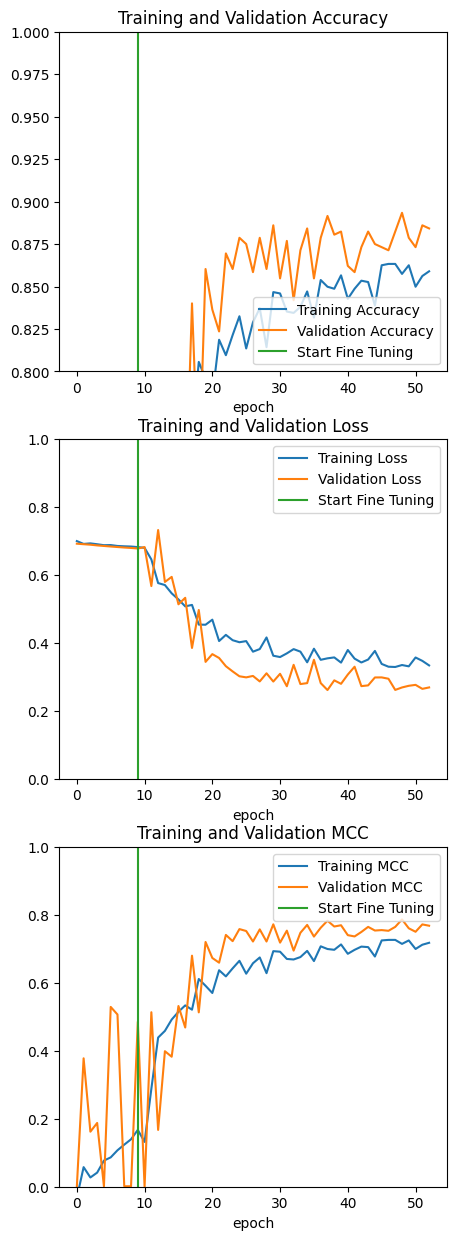

In [44]:
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(matthews_correlation_coefficient, label='Training MCC')
plt.plot(val_matthews_correlation_coefficient, label='Validation MCC')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation MCC')
plt.xlabel('epoch')

plt.show()

In [45]:
# Loss
min_loss_index = np.argmin(history_fine.history['loss'])
min_loss_value = round(history_fine.history['loss'][min_loss_index], 4)
print(f'The epoch with the lowest loss is: {min_loss_index + 1} (Loss: {min_loss_value})')

# Validation Loss
min_val_loss_index = np.argmin(history_fine.history['val_loss'])
min_val_loss_value = round(history_fine.history['val_loss'][min_val_loss_index], 4)
print(f'The epoch with the lowest val_loss is: {min_val_loss_index + 1} (Val Loss: {min_val_loss_value})')

# Accuracy
max_accuracy_index = np.argmax(history_fine.history['accuracy'])
max_accuracy_value = round(history_fine.history['accuracy'][max_accuracy_index], 4)
print(f'The epoch with the highest accuracy is: {max_accuracy_index + 1} (Accuracy: {max_accuracy_value})')

# Validation Accuracy
max_val_acc_index = np.argmax(history_fine.history['val_accuracy'])
max_val_acc_value = round(history_fine.history['val_accuracy'][max_val_acc_index], 4)
print(f'The epoch with the highest validation accuracy is: {max_val_acc_index + 1} (Val Accuracy: {max_val_acc_value})')

# Matthews Correlation Coefficient (MCC)
max_mcc_index = np.argmax(history_fine.history['mcc'])
max_mcc_value = round(history_fine.history['mcc'][max_mcc_index], 4)
print(f'The epoch with the highest MCC is: {max_mcc_index + 1} (MCC: {max_mcc_value})')

# Validation MCC
max_val_mcc_index = np.argmax(history_fine.history['val_mcc'])
max_val_mcc_value = round(history_fine.history['val_mcc'][max_val_mcc_index], 4)
print(f'The epoch with the highest validation MCC is: {max_val_mcc_index + 1} (Val MCC: {max_val_mcc_value})')

best_epoch_model = max_val_mcc_index + 1

The epoch with the lowest loss is: 38 (Loss: 0.33)
The epoch with the lowest val_loss is: 28 (Val Loss: 0.2621)
The epoch with the highest accuracy is: 37 (Accuracy: 0.8633)
The epoch with the highest validation accuracy is: 39 (Val Accuracy: 0.8934)
The epoch with the highest MCC is: 38 (MCC: 0.7266)
The epoch with the highest validation MCC is: 39 (Val MCC: 0.7868)


In [46]:
#model.load_weights("/content/drive/MyDrive/drweights/EfficientNetV2B3_d5b.hdf5")


In [47]:
loss, accuracy, mcc = model.evaluate(test_generator)
print('Test accuracy :', accuracy, 'Test MCC :', mcc)

18/18 [==============================] - 122s 7s/step - loss: 0.2423 - accuracy: 0.9091 - mcc: 0.8182
Test accuracy : 0.9090909361839294 Test MCC : 0.8182210326194763


In [48]:
#from sklearn.metrics import confusion_matrix, classification_report

# Predicting on the entire test set
predictions = model.predict(test_generator)
thresholded_predictions = (predictions > 0.5).astype(int).flatten()

# Assuming your test_generator has the true labels in test_generator.classes
true_labels = test_generator.labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, thresholded_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Generate and print classification report
report = classification_report(true_labels, thresholded_predictions)
print("\nClassification Report:")
print(report)




18/18 [==============================] - 5s 127ms/step
Confusion Matrix:
[[119 140]
 [148 143]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.46      0.45       259
           1       0.51      0.49      0.50       291

    accuracy                           0.48       550
   macro avg       0.48      0.48      0.48       550
weighted avg       0.48      0.48      0.48       550



In [49]:
class_names = ['No_DR', 'Yes_Dr']

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)


# Calculate the metrics with conditions to handle division by zero
TPR = np.divide(TP, TP + FN, out=np.zeros_like(TP), where=(TP+FN)!=0)
TNR = np.divide(TN, TN + FP, out=np.zeros_like(TN), where=(TN+FP)!=0)
PPV = np.divide(TP, TP + FP, out=np.zeros_like(TP), where=(TP+FP)!=0)
NPV = np.divide(TN, TN + FN, out=np.zeros_like(TN), where=(TN+FN)!=0)
FPR = np.divide(FP, FP + TN, out=np.zeros_like(FP), where=(FP+TN)!=0)
FNR = np.divide(FN, TP + FN, out=np.zeros_like(FN), where=(TP+FN)!=0)
FDR = np.divide(FP, TP + FP, out=np.zeros_like(FP), where=(TP+FP)!=0)
ACC = np.divide(TP + TN, TP + FP + FN + TN, out=np.zeros_like(TP+TN), where=(TP+FP+FN+TN)!=0)

# Print metrics for each class
for i in range(len(class_names)):
    print(f"Class - {class_names[i]}")
    print(f"  Sensitivity: {TPR[i]}")
    print(f"  Specificity: {TNR[i]}")
    print(f"  Precision: {PPV[i]}")
    print(f"  Negative Predictive Value: {NPV[i]}")
    print(f"  False Positive Rate: {FPR[i]}")
    print(f"  False Negative Rate: {FNR[i]}")
    print(f"  False Discovery Rate: {FDR[i]}")
    print(f"  Overall Accuracy: {ACC[i]}\n")

Class - No_DR
  Sensitivity: 0.4594594594594595
  Specificity: 0.49140893470790376
  Precision: 0.44569288389513106
  Negative Predictive Value: 0.5053003533568905
  False Positive Rate: 0.5085910652920962
  False Negative Rate: 0.5405405405405406
  False Discovery Rate: 0.5543071161048689
  Overall Accuracy: 0.4763636363636364

Class - Yes_Dr
  Sensitivity: 0.49140893470790376
  Specificity: 0.4594594594594595
  Precision: 0.5053003533568905
  Negative Predictive Value: 0.44569288389513106
  False Positive Rate: 0.5405405405405406
  False Negative Rate: 0.5085910652920962
  False Discovery Rate: 0.49469964664310956
  Overall Accuracy: 0.4763636363636364



<ipython-input-50-86800b8bc2b8>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



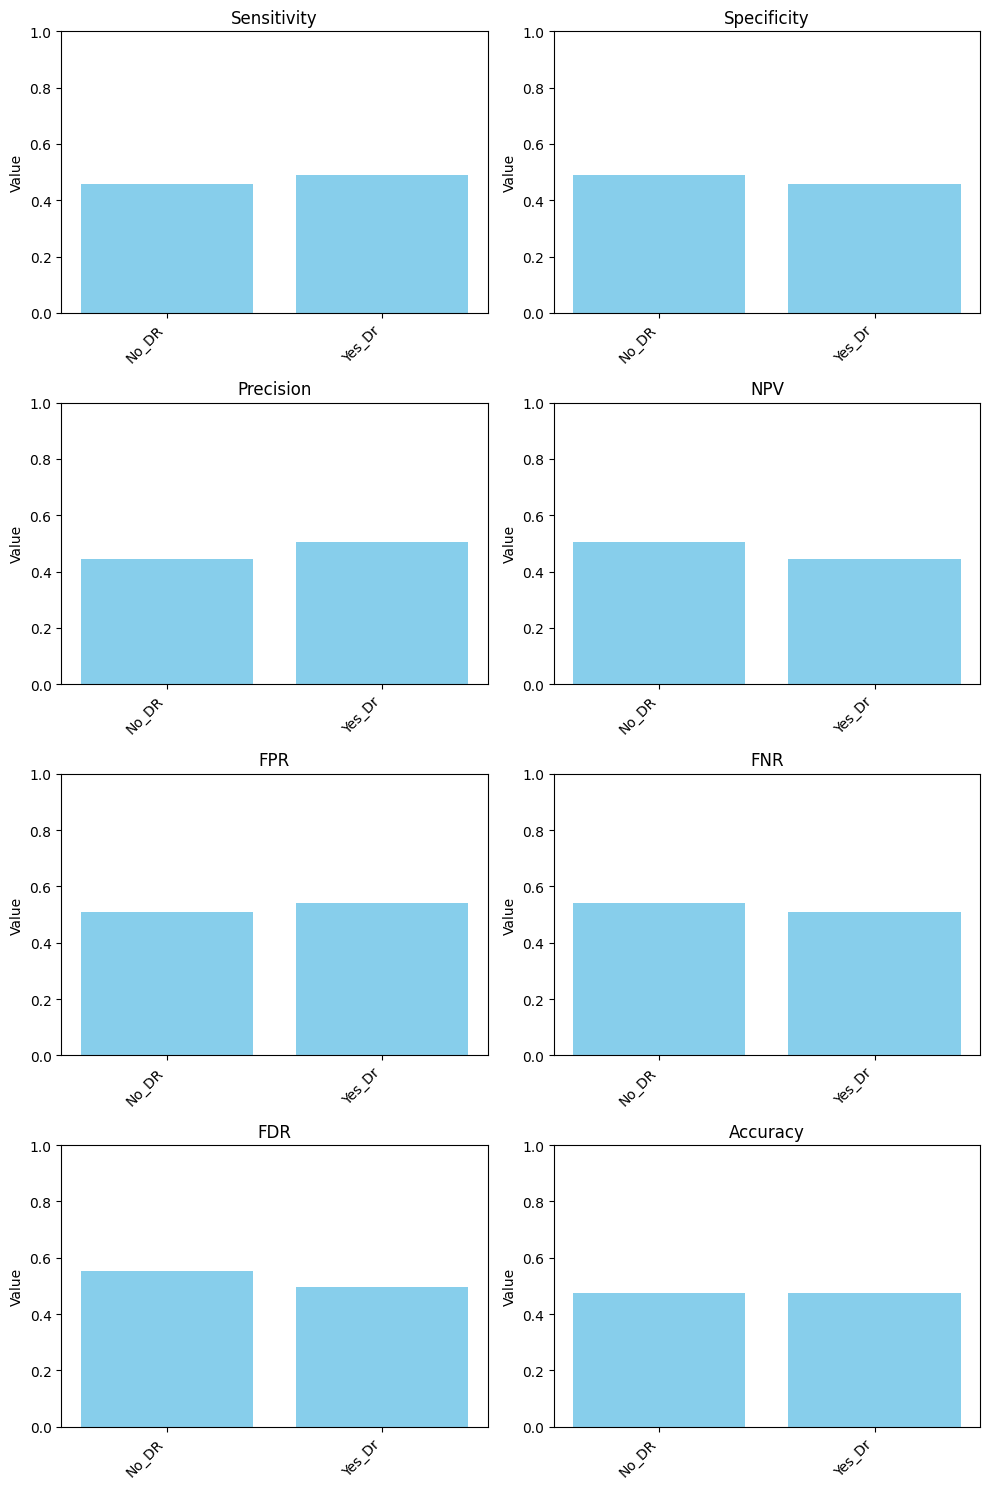

In [50]:
# Metrics to plot
metrics = [TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC]
metric_names = ['Sensitivity', 'Specificity', 'Precision', 'NPV', 'FPR', 'FNR', 'FDR', 'Accuracy']

# Plotting
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # Adjust the size as needed
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.bar(class_names, metrics[i], color='skyblue')
    ax.set_title(metric_names[i])
    ax.set_ylim(0, 1)  # Assuming metrics are between 0 and 1
    ax.set_ylabel('Value')
    ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()

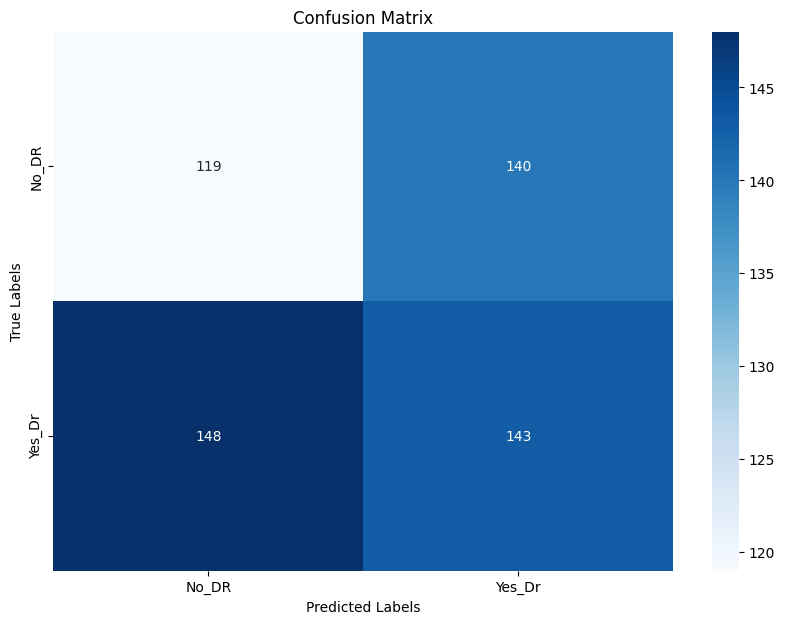

In [51]:
class_labels = class_names

plt.figure(figsize=(10, 7))

# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Evaluate on secondary DR Detection eyePACS test dataset

In [52]:
eyepacs_df = pd.read_csv('/content/drive/MyDrive/minitest.csv')
eyepacs_df.rename(columns={'image': 'Image', 'level': 'Labels'}, inplace=True)
eyepacs_df['Labels'].replace({0: 'No_DR', 1: 'Yes_DR', 2: 'Yes_DR', 3: 'Yes_DR', 4: 'Yes_DR'}, inplace=True)
eyepacs_df['Image'] = eyepacs_df['Image'] + '.jpeg'
import pandas as pd

# Assuming 'Labels' column in your DataFrame has 'No_DR' and 'Yes_DR'
eyepacs_df['Encoded_Labels'] = eyepacs_df['Labels'].replace({'No_DR': 0, 'Yes_DR': 1})

eyepacs_df.head()

,Image,Labels,Encoded_Labels
0,17123_right.jpeg,No_DR,0
1,12616_right.jpeg,No_DR,0
2,6541_left.jpeg,No_DR,0
3,14418_right.jpeg,No_DR,0
4,39598_left.jpeg,No_DR,0


In [53]:
# eyepacs generator

eyepacs_datagen = ImageDataGenerator(rescale = 1./255)

base_path = '/content/drive/My Drive/eyepacs'  # Your base path

eyepacs_generator = eyepacs_datagen.flow_from_dataframe(
    eyepacs_df,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Encoded_Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="raw",
    batch_size=32)

Found 1001 validated image filenames.


In [54]:
loss, accuracy, mcc = model.evaluate(eyepacs_generator)
print('Test accuracy :', accuracy, 'Test MCC :', mcc)

32/32 [==============================] - 236s 8s/step - loss: 0.7724 - accuracy: 0.6414 - mcc: 0.0033
Test accuracy : 0.6413586139678955 Test MCC : 0.0033162692561745644


In [55]:
# Predicting on the entire test set
predictions = model.predict(eyepacs_generator)
thresholded_predictions = (predictions > 0.5).astype(int).flatten()

# Assuming your test_generator has the true labels in test_generator.classes
true_labels = eyepacs_generator.labels

# Generate the confusion matrix
epconf_matrix = confusion_matrix(true_labels, thresholded_predictions)
print("Confusion Matrix:")
print(epconf_matrix)

# Generate and print classification report
report = classification_report(true_labels, thresholded_predictions)
print("\nClassification Report:")
print(report)

32/32 [==============================] - 3s 94ms/step
Confusion Matrix:
[[587 148]
 [213  53]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       735
           1       0.26      0.20      0.23       266

    accuracy                           0.64      1001
   macro avg       0.50      0.50      0.50      1001
weighted avg       0.61      0.64      0.62      1001



In [56]:
class_names = ['No_DR', 'Yes_DR']

FP = epconf_matrix.sum(axis=0) - np.diag(epconf_matrix)
FN = epconf_matrix.sum(axis=1) - np.diag(epconf_matrix)
TP = np.diag(epconf_matrix)
TN = epconf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)


# Calculate the metrics with conditions to handle division by zero
TPR = np.divide(TP, TP + FN, out=np.zeros_like(TP), where=(TP+FN)!=0)
TNR = np.divide(TN, TN + FP, out=np.zeros_like(TN), where=(TN+FP)!=0)
PPV = np.divide(TP, TP + FP, out=np.zeros_like(TP), where=(TP+FP)!=0)
NPV = np.divide(TN, TN + FN, out=np.zeros_like(TN), where=(TN+FN)!=0)
FPR = np.divide(FP, FP + TN, out=np.zeros_like(FP), where=(FP+TN)!=0)
FNR = np.divide(FN, TP + FN, out=np.zeros_like(FN), where=(TP+FN)!=0)
FDR = np.divide(FP, TP + FP, out=np.zeros_like(FP), where=(TP+FP)!=0)
ACC = np.divide(TP + TN, TP + FP + FN + TN, out=np.zeros_like(TP+TN), where=(TP+FP+FN+TN)!=0)

# Print metrics for each class
for i in range(len(class_names)):
    print(f"Class - {class_names[i]}")
    print(f"  Sensitivity: {TPR[i]}")
    print(f"  Specificity: {TNR[i]}")
    print(f"  Precision: {PPV[i]}")
    print(f"  Negative Predictive Value: {NPV[i]}")
    print(f"  False Positive Rate: {FPR[i]}")
    print(f"  False Negative Rate: {FNR[i]}")
    print(f"  False Discovery Rate: {FDR[i]}")
    print(f"  Overall Accuracy: {ACC[i]}\n")



Class - No_DR
  Sensitivity: 0.7986394557823129
  Specificity: 0.19924812030075187
  Precision: 0.73375
  Negative Predictive Value: 0.263681592039801
  False Positive Rate: 0.8007518796992481
  False Negative Rate: 0.20136054421768707
  False Discovery Rate: 0.26625
  Overall Accuracy: 0.6393606393606394

Class - Yes_DR
  Sensitivity: 0.19924812030075187
  Specificity: 0.7986394557823129
  Precision: 0.263681592039801
  Negative Predictive Value: 0.73375
  False Positive Rate: 0.20136054421768707
  False Negative Rate: 0.8007518796992481
  False Discovery Rate: 0.736318407960199
  Overall Accuracy: 0.6393606393606394



<ipython-input-57-86800b8bc2b8>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



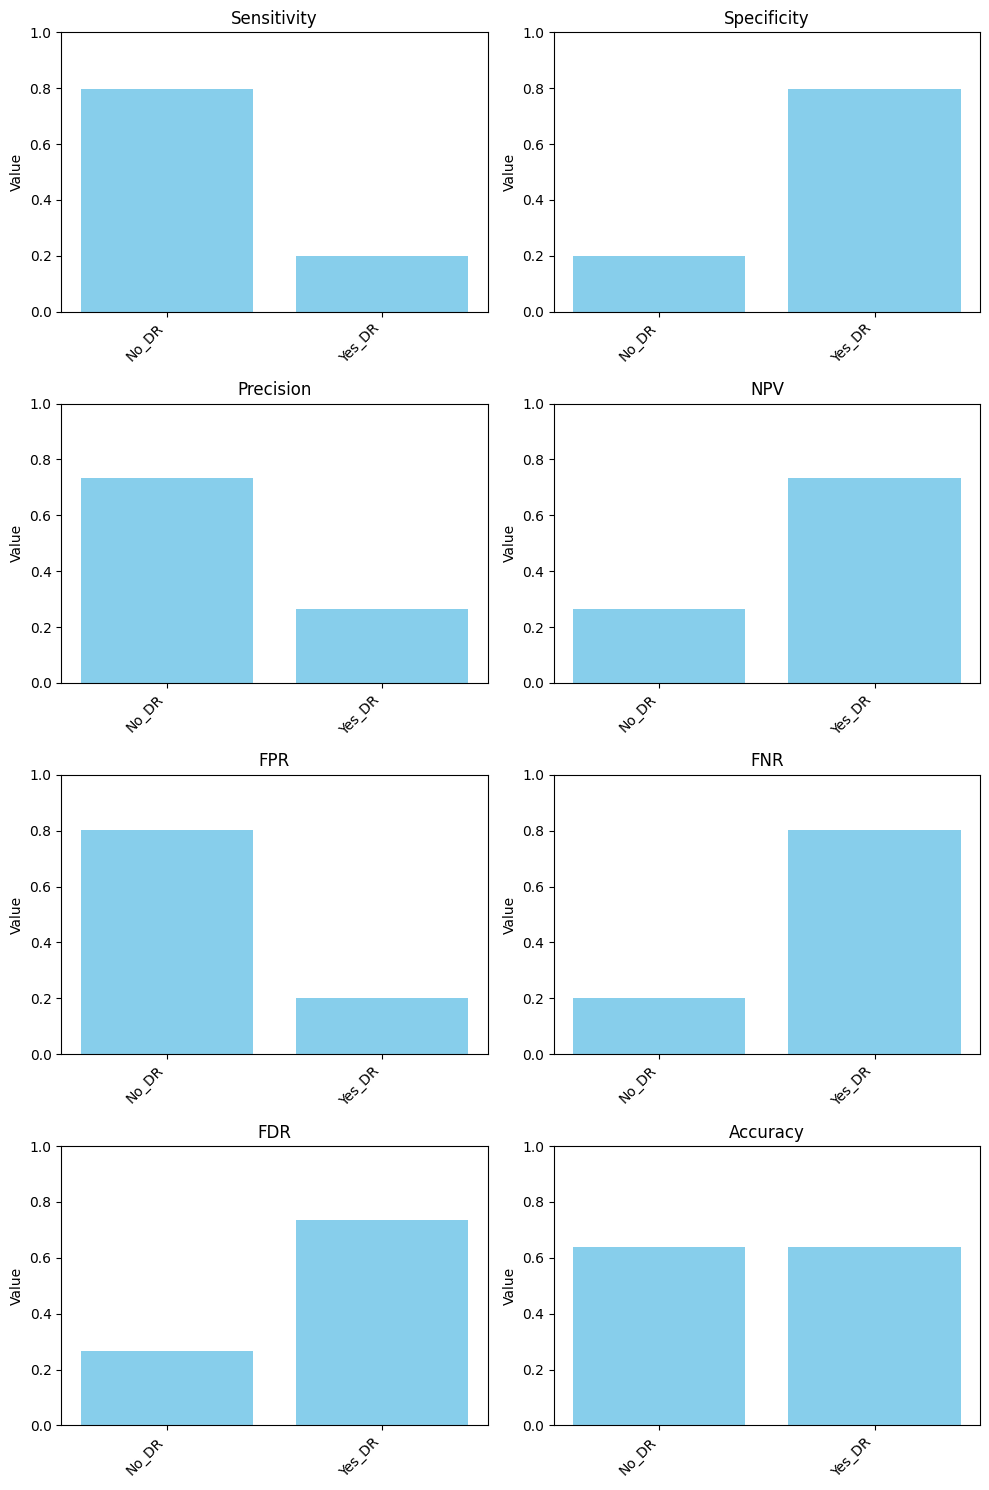

In [57]:
# Metrics to plot
metrics = [TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC]
metric_names = ['Sensitivity', 'Specificity', 'Precision', 'NPV', 'FPR', 'FNR', 'FDR', 'Accuracy']

# Plotting
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # Adjust the size as needed
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.bar(class_names, metrics[i], color='skyblue')
    ax.set_title(metric_names[i])
    ax.set_ylim(0, 1)  # Assuming metrics are between 0 and 1
    ax.set_ylabel('Value')
    ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()


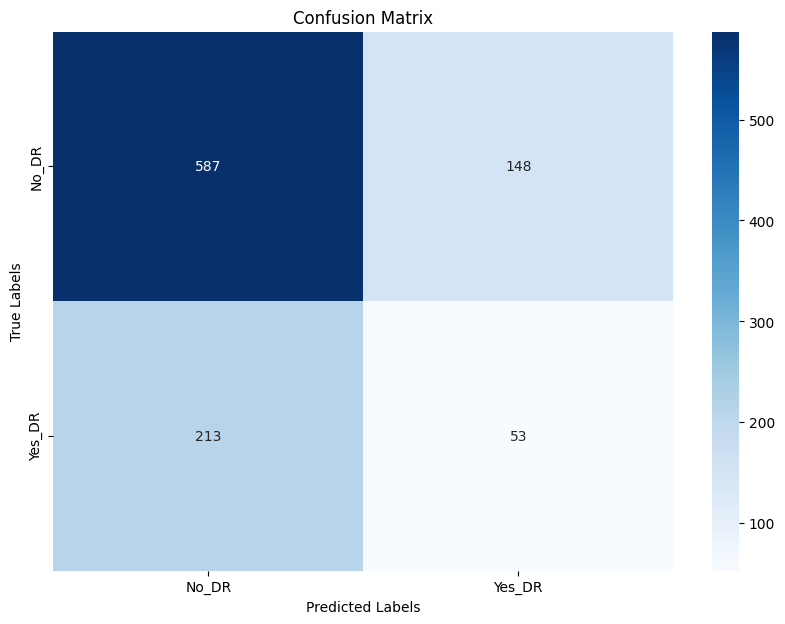

In [58]:
class_labels = class_names

plt.figure(figsize=(10, 7))

# Create a heatmap
sns.heatmap(epconf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()